In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('png', 'pdf')

# plot parameters
rcParams = {
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.figsize': [4, 3],
    'grid.linewidth': 0.0,
    'figure.subplot.hspace': 0.6,
    'figure.subplot.wspace': 0.6
   }

import matplotlib as mpl
mpl.rcParams.update(rcParams)

np.set_printoptions(precision=2)
np.set_printoptions(suppress=1)
np.seterr(all='print')

from sta import *

# set all required parameters

In [2]:
# number of pixels in stimulus
N       = 64

# data directory
root = '/disk/scratch/mhennig/P76_20_06_17/'
datadir = root

# clustered spikes
dataset = 'P76_20_06_17_swn_stim2_ctl_INT_v28_HS2_clustered.hdf5'

# trigger file
stim_trigger_fn = datadir+'Trigger_stim2_Basic.mat'

transpose = True # In case stimulus should be transposed, usually yes but false for P91
radius = 22 # radius around each cell location

# store STAs in this file
outfile = dataset.replace('.hdf5','_sta.hdf5')

# STA parameters
t_past   = 0.60  # seconds
t_future = 0 # seconds
stim_len = 235. # stimulus duration in sample frames (approx)
min_interval = int(stim_len/4) # step size for STA

# the stimulus (coverted to matlab array)
stimdir = '/disk/scratch/mhennig/P91_05_07_17_TestMotionSeq/detected/'
swn_fn  = stimdir+'pixels_allframes.mat'


# read stimulus and spikes

In [3]:
# read stimulus
print('Loading stimulus %s'%(swn_fn))
swn = load_sta_stimulus(swn_fn, N)
print('Stimulus shape',swn.shape)

# read spikes
f  = h5py.File(datadir+dataset,'r')
Fs = f['Sampling'].value
duration = int(np.max(f['times']))
# Convert STA parameters to samples
window = np.array([-t_future,t_past])
window_frames = np.int32(np.round(window*Fs))
window_length_frames = np.diff(window_frames)
window = (window_frames[0], window_frames[1], min_interval)

print('Sampling rate is %sHz'%Fs)
print('Recording is %s sec long' % (duration/Fs))

# read stimulus triggers
triggers = load_sta_triggers(stim_trigger_fn, duration, ntrials = 9)


Loading stimulus /disk/scratch/mhennig/P91_05_07_17_TestMotionSeq/detected/pixels_allframes.mat
Stimulus shape (27000, 64, 64)
Sampling rate is 7062.06Hz
Recording is 1207.0391642098764 sec long
file format False
tsm (27000,) ntrig 27000
dt 3000
trigs (27000,)
frame_len 235.0


In [4]:
# get info about the units
cid, n = np.unique(f['cluster_id'], return_counts=True)
if f['centres'].shape[0]>4:
    nspikes = np.zeros(f['centres'].shape[0], dtype=int)
else:
    nspikes = np.zeros(f['centres'].shape[1], dtype=int)
nspikes[cid] = n.astype(int)
# select units with sufficintly high spike count
MIN_SPIKES = 1000
units = np.where(nspikes>=MIN_SPIKES)[0]
print('We have {} units with at least {} spikes'.format(len(units),MIN_SPIKES))

We have 693 units with at least 1000 spikes


In [5]:
# select a few for testing (note unit selection can be different)
sta_units = units[6:12]

In [6]:
# compute STAs

STAs = joblib.Parallel(
    n_jobs=-1, backend="threading", verbose=1)(
    joblib.delayed(compute_sta)(f, i, swn, triggers, window=window, 
                                transpose=transpose, radius=radius) for i in sta_units)


# compute Gaussian fits

fits = joblib.Parallel(
    n_jobs=-1, backend="threading", verbose=1)(
    joblib.delayed(fit_sta_gaussian)(STAs[i],None) for i in range(len(sta_units)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   36.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished


4
Peak at 23:21 frame 8
Peak at 23:21
5
Peak at 21:19 frame 10
Peak at 21:19
6
Peak at 22:19 frame 9
Peak at 22:19
7
Peak at 22:20 frame 9
Peak at 22:20
12
Peak at 21:20 frame 8
Peak at 21:20
13
Peak at 23:20 frame 8
Peak at 23:20


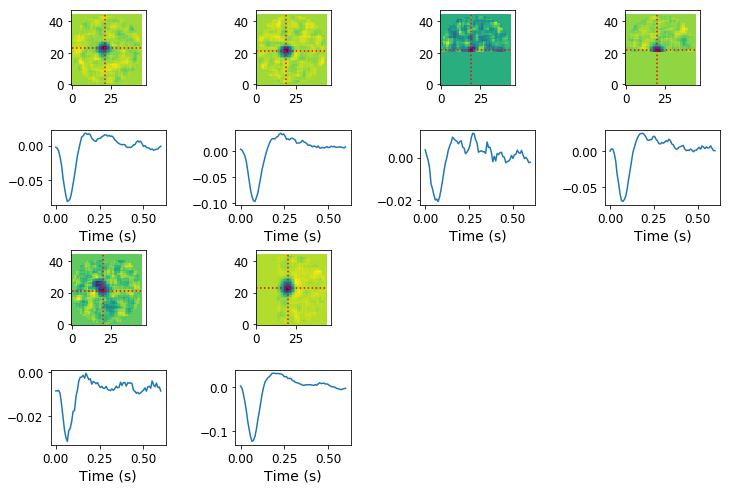

In [7]:
nc=4
nr=len(sta_units)//nc+1
plt.figure(figsize=(12,nr*2*2))
for i,u in enumerate(sta_units):
    print(i//nc*nc+nc+i)
    plt.subplot(2*nr,nc,i//nc*nc+i+1)
    plot_sta_2d(STAs[i])
    plt.subplot(2*nr,nc,i//nc*nc+nc+i+1)
    plot_sta_peak(STAs[i],window,Fs)

Peak at 23:21 frame 8


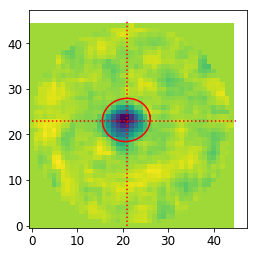

In [11]:
# plot with Gaussian fit

plot_sta_2d(STAs[0],fits[0][0])